In [1]:
# General imports
import pandas as pd

# Grid search
from library.genetic_algorithms.grid_search_parallelized import grid_search_par
from library.genetic_algorithms.mutation import swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation
from library.genetic_algorithms.crossover import cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover
from library.genetic_algorithms.selection import fitness_proportionate_selection, ranking_selection, tournament_selection

# Plotting
from matplotlib import pyplot as plt

In [2]:
seating_data= pd.read_csv("seating_data.csv", index_col=0)

In [3]:
relationships_mtx=seating_data.to_numpy()

In [4]:
relationships_mtx

array([[   0, 5000,    0, ...,    0,    0,    0],
       [5000,    0,  700, ...,    0,    0,    0],
       [   0,  700,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,  700,  700],
       [   0,    0,    0, ...,  700,    0,  900],
       [   0,    0,    0, ...,  700,  900,    0]], shape=(64, 64))

# Experiment with different mutation, crossover and selection methods

## Fixed hyperparameters:
- population size = 100
- max generations = 100
- crossover probability = 0.9
- mutation probability = 0.1
- when selection method is tournment: tournment size = 3

In [5]:
# Testing grid search code 

results = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation],
    crossover_functions=[cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover],
    selection_functions=[fitness_proportionate_selection, ranking_selection, tournament_selection],
    elitism=[0,1]
)

results #results is empty, therefore nothing is printed

[{'mutation': 'heuristic_mutation',
  'crossover': 'geometric_crossover',
  'selection': 'tournament_selection',
  'elitism': 1,
  'last_gen_avg_fitness': np.float64(78346.66666666667),
  'solution_highest_fitness': <library.SA_problem.seating_arrangement.SASolution at 0x20341fb3440>,
  'execution_time': 21.119258880615234}]

Each combination (w/ 30 runs) takes around 6 min.
- 48 combinations: 4.8 h.

In [6]:
results_table1 = pd.DataFrame(results).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table1

,mutation,crossover,selection,elitism,last_gen_avg_fitness,solution_highest_fitness,execution_time
0,heuristic_mutation,geometric_crossover,tournament_selection,1,78346.667,"Table 0: [28, 29, 30, 31, 32, 33, 34, 35] Table 1: [36, 37, 39, 40, 41, 42, 43, 49] Table 2: [46, 47, 58, 59, 60, 61, 62, 63] Table 3: [22, 23, 24, 25, 26, 27, 45, 48] Table 4: [50, 51, 52, 53, 54, 55, 56, 57] Table 5: [10, 11, 12, 13, 14, 21, 38, 44] Table 6: [4, 5, 15, 16, 17, 18, 19, 20] Table 7: [0, 1, 2, 3, 6, 7, 8, 9]",21.119


# Experiment with different nr of elits for best mutation, crossover and selection method

In [7]:
results = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[], # add best mutation
    crossover_functions=[], # add best crossover
    selection_functions=[], # add best selection
    elitism=[0, 5]
)

Each combination (w/ 30 runs) takes around 6 min.
- 2 combinations: 12 min.

In [8]:
results_table2 = pd.DataFrame(results).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table2

# Experimental Analysis

In [2]:
avg_fitness_per_gen= pd.read_csv("avg_fitness_per_generation.csv")
fitness_per_run= pd.read_csv("fitness_per_run.csv")

In [8]:
print(avg_fitness_per_gen.shape)
print(fitness_per_run.shape)

(9600, 6)
(288000, 7)


## Tracking Performance Across Generations for Different Operators

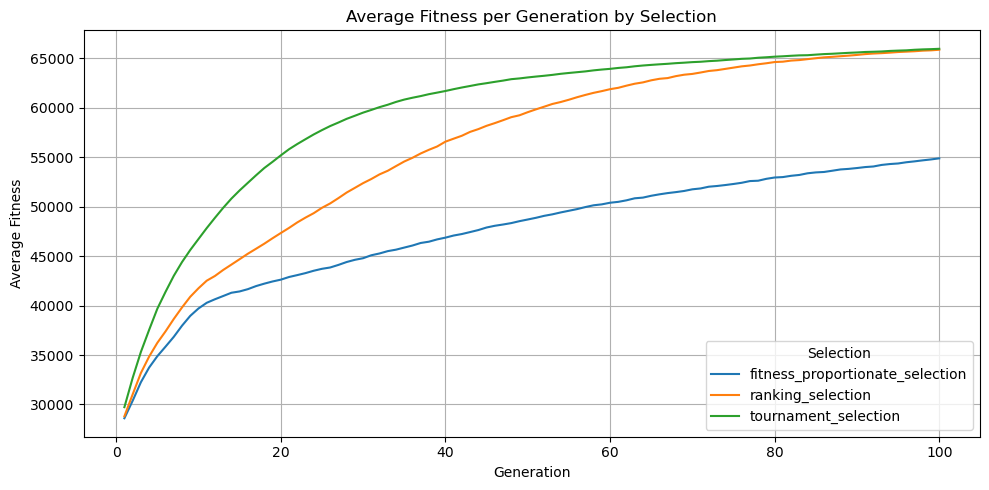

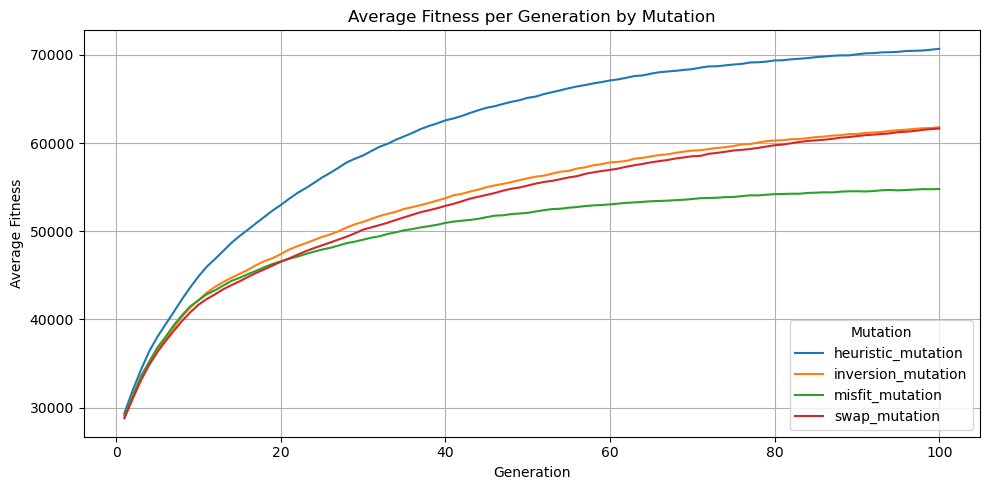

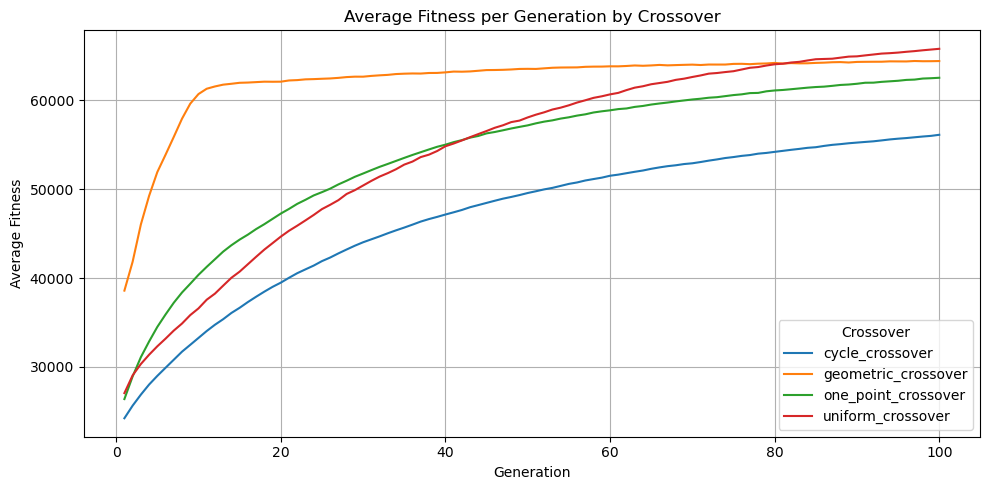

In [20]:
def plot_avg_fitness_by_operator(df, operator_name):
    grouped = df.groupby([operator_name, "generation"])["avg_fitness"].mean().reset_index()

    plt.figure(figsize=(10, 5))
    for op in grouped[operator_name].unique():
        subset = grouped[grouped[operator_name] == op]
        plt.plot(subset["generation"], subset["avg_fitness"], label=op)

    plt.title(f"Average Fitness per Generation by {operator_name.capitalize()}")
    plt.xlabel("Generation")
    plt.ylabel("Average Fitness")
    plt.legend(title=operator_name.capitalize(), loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot para cada operador
for operator in ["selection", "mutation", "crossover"]:
    plot_avg_fitness_by_operator(avg_fitness_per_gen, operator)

## Plot average fitness per gen 

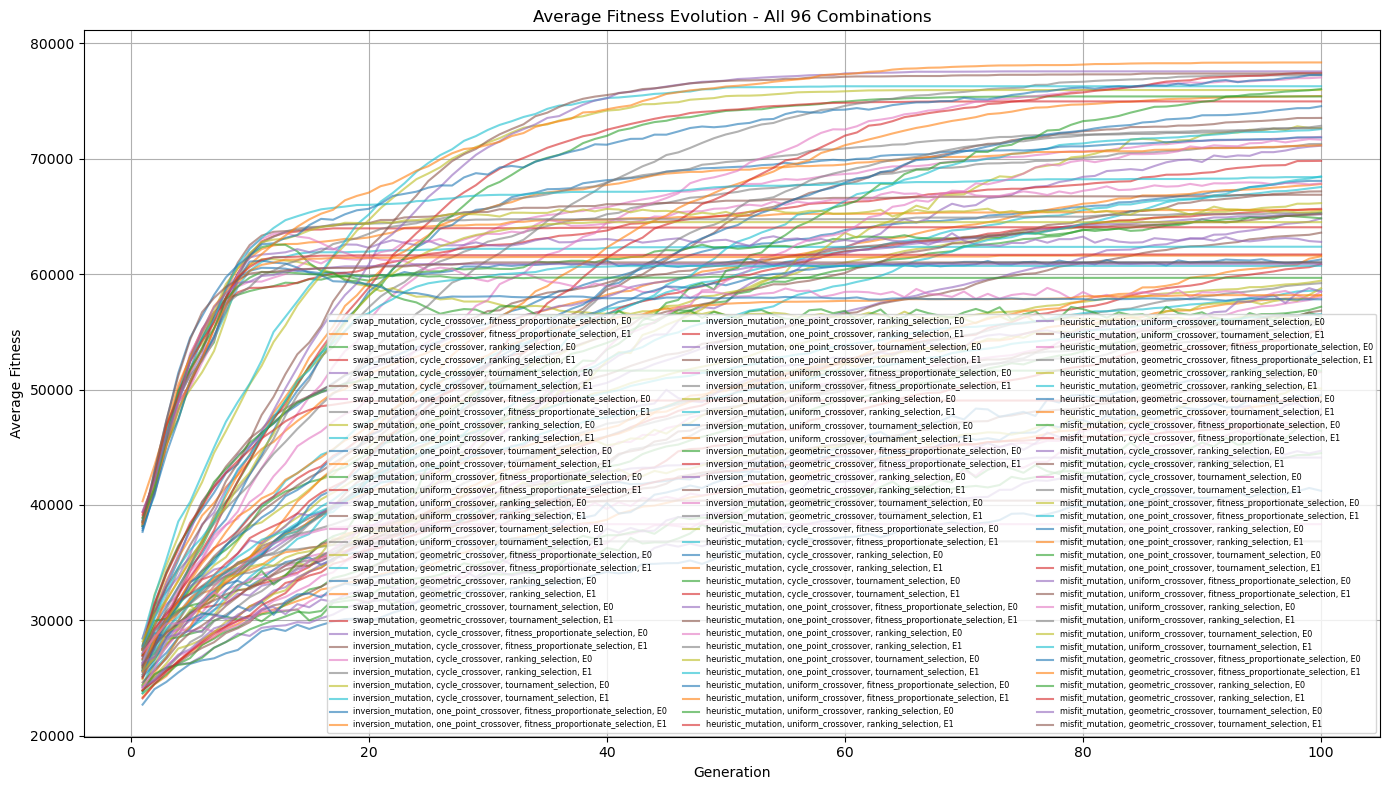

In [ ]:
avg_fitness_per_gen["combination"] = avg_fitness_per_gen.apply(
    lambda row: f"{row["mutation"]}, {row["crossover"]}, {row["selection"]}, E{row["elitism"]}",
    axis=1
)

# Plot all 48 curves
plt.figure(figsize=(14, 8))

for combo in avg_fitness_per_gen["combination"].unique():
    subset = avg_fitness_per_gen[avg_fitness_per_gen["combination"] == combo]
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo, alpha=0.6)

plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Average Fitness Evolution - All 96 Combinations")
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize="xx-small", ncol=3, loc="lower right")
plt.show()

Due to the high number of combinations being evaluated, we will focus on plotting only the top 5 combinations. These top 5 are selected based on achieving the highest average fitness values in the final generation. By doing so, we can clearly visualize and compare the best-performing configurations in terms of fitness evolution over the generations.

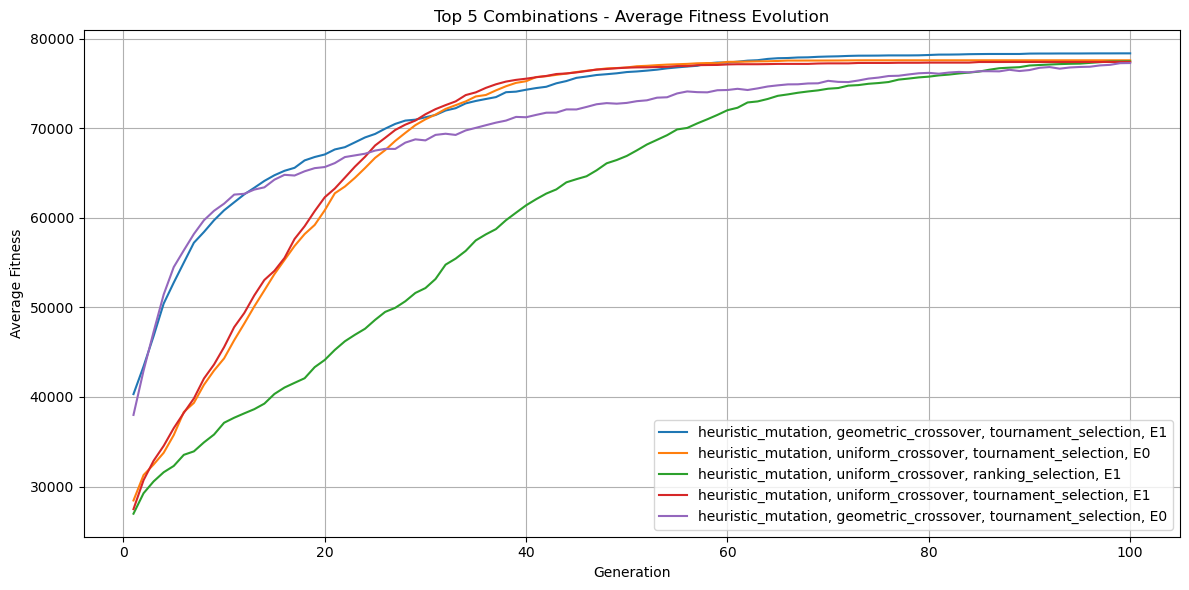

In [10]:
# Filter the last generation
last_gen = avg_fitness_per_gen[avg_fitness_per_gen["generation"] == avg_fitness_per_gen["generation"].max()]

# Select top 5 combinations by average fitness in the last generation
top5_combinations = last_gen.sort_values(by="avg_fitness", ascending=False)["combination"].head(5).unique()

# Filter data for these top 5 combinations
df_top5 = avg_fitness_per_gen[avg_fitness_per_gen["combination"].isin(top5_combinations)]

# Plot the curves
plt.figure(figsize=(12, 6))
for combo in top5_combinations:
    subset = df_top5[df_top5["combination"] == combo]
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo)

plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Top 5 Combinations - Average Fitness Evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We are going to add the standard desviation to our plot

In [ ]:
stats = fitness_per_run.groupby(
    ["mutation", "crossover", "selection", "elitism", "generation"]
)["fitness"].agg(["mean", "std"]).reset_index()


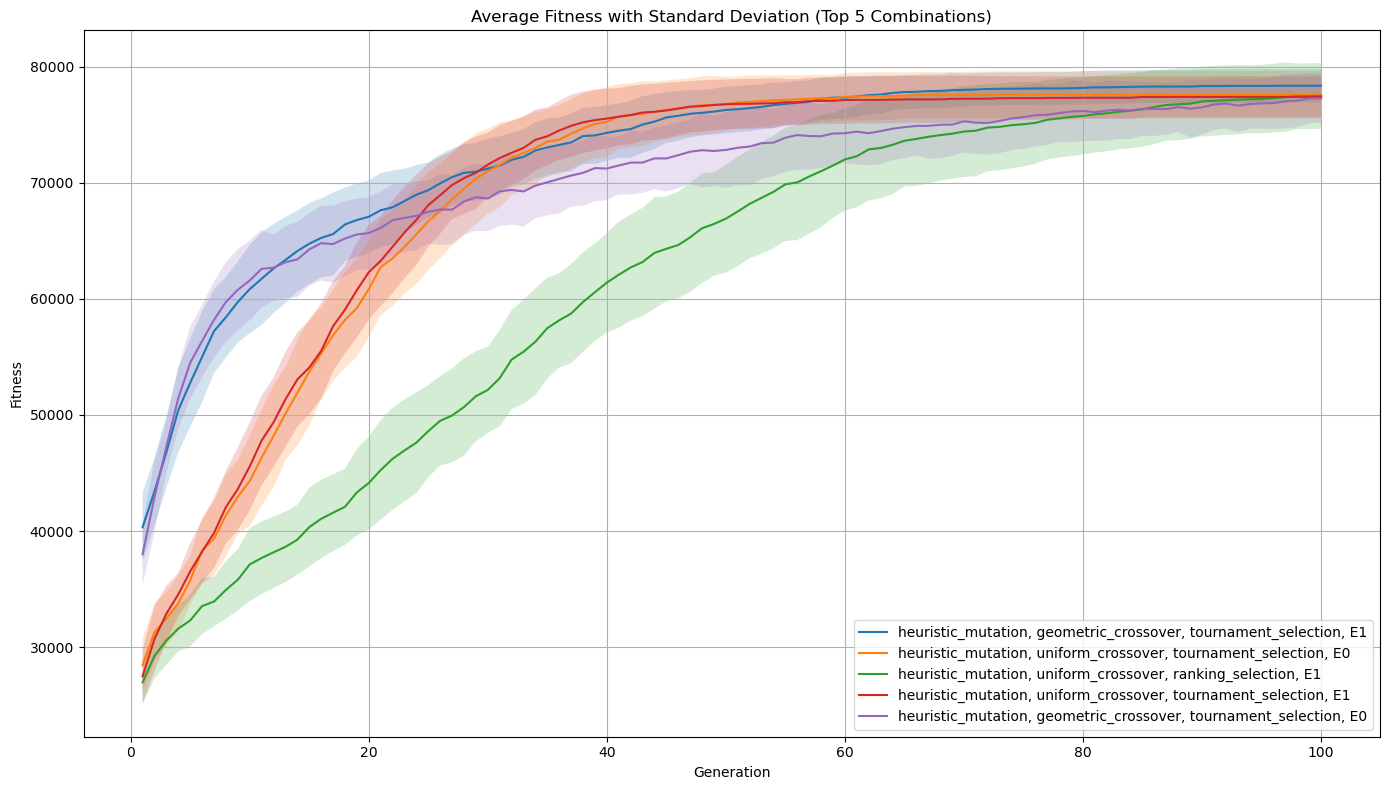

In [21]:
stats["combination"] = stats.apply(
    lambda row: f"{row["mutation"]}, {row["crossover"]}, {row["selection"]}, E{row["elitism"]}",
    axis=1
)

stats.rename(columns={"mean": "avg_fitness", "std": "std_fitness"}, inplace=True)

stats_top5 = stats[stats["combination"].isin(top5_combinations)]


plt.figure(figsize=(14, 8))

for combo in top5_combinations:
    subset = stats_top5[stats_top5["combination"] == combo]
    
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo)
    
    # Sombrear o intervalo avg ± std
    plt.fill_between(
        subset["generation"],
        subset["avg_fitness"] - subset["std_fitness"],
        subset["avg_fitness"] + subset["std_fitness"],
        alpha=0.2
    )

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Average Fitness with Standard Deviation (Top 5 Combinations)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Performs statistical tests

# Calculate success rate